In [395]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [426]:
import random as ran
from IPython.display import clear_output
from src import spotify, dp, utils, DB
from sklearn.metrics.pairwise import euclidean_distances as euc
import pandas as pd
import math as mt
import numpy as np
import matplotlib.pyplot as plt

db = DB()

In [505]:
ms = utils.MatchingSystem()

# K Checking
- 새로운 K의 갯수를 만들 수 있는지 확인하는 과정

In [506]:
ms.check()

현재 seed 음악 갯수 : 340
K 갯수 : 13 (후에 체크 방식으로 진행)


# KMeans Run

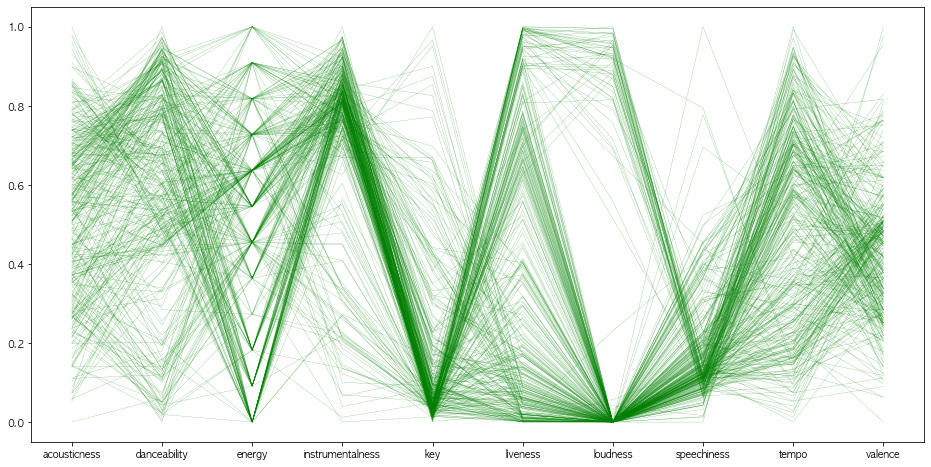

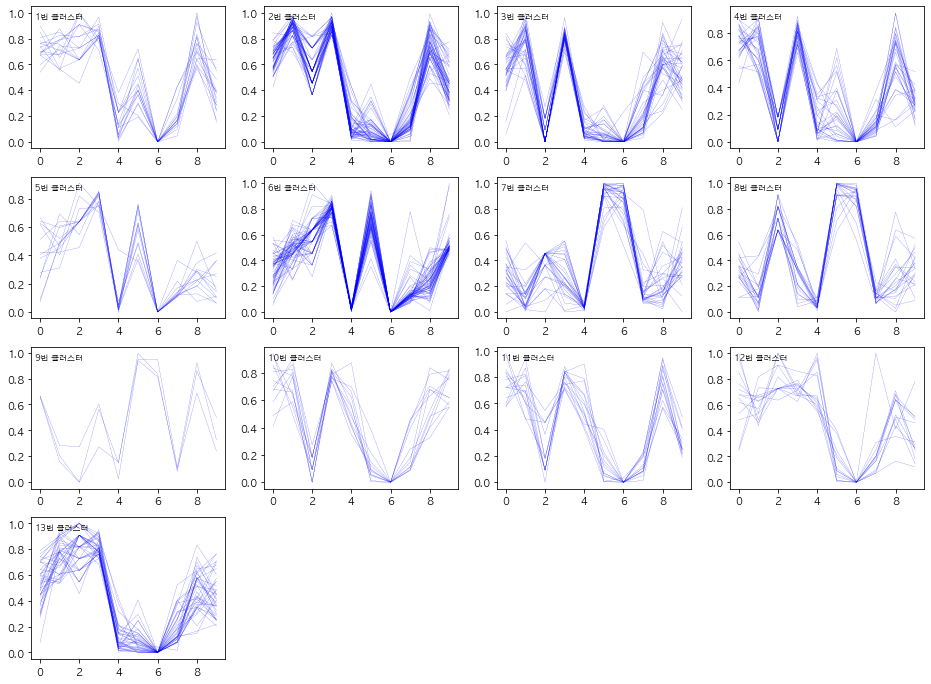

In [509]:
ms.kmeans_run()

clear_output(wait=True)

seed_features = ms.seed_features
norm_features = ms.norm_features
kmeans = ms.kmeans

utils.visual_norm_data(None, norm_features)
utils.visual_cluster_data(norm_features, kmeans)

# Mail Box Matching

In [510]:
ms.box_matching()

ms.mail_box_radar.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
623f2515ff1c441a392ab38c,0,0,0,0,0,0,100,0,0,0,0,0,0
623f2515ff1c441a392ab38d,0,6,0,0,0,94,0,0,0,0,0,0,0
623f2515ff1c441a392ab38e,0,0,0,0,0,50,15,35,0,0,0,0,0
623f2515ff1c441a392ab38f,0,17,0,0,0,83,0,0,0,0,0,0,0
623f2515ff1c441a392ab390,0,14,0,0,0,0,0,0,0,0,14,71,0


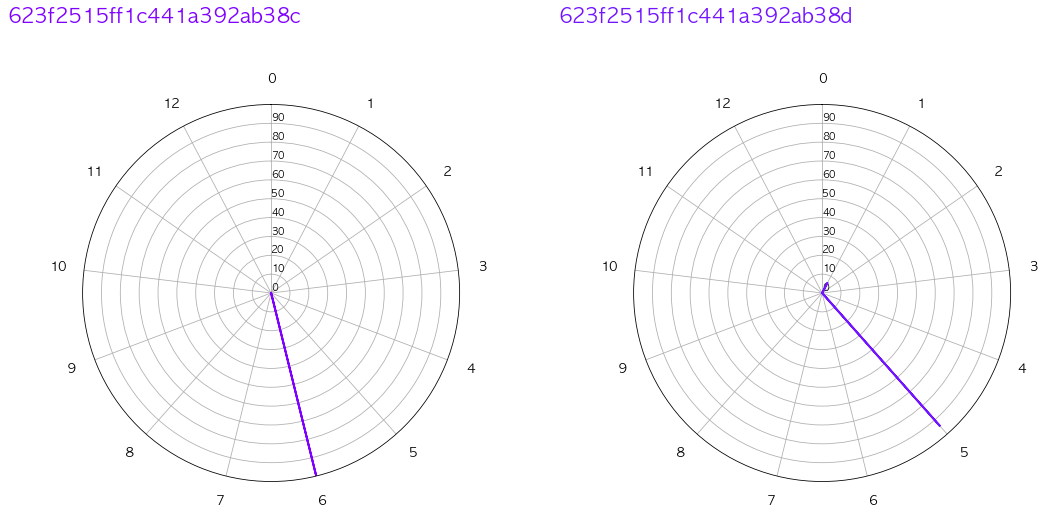

계속 진행하시려면 next, 종료는 아무거나 입력해주세요.


In [511]:
ms.visual_radar_step()

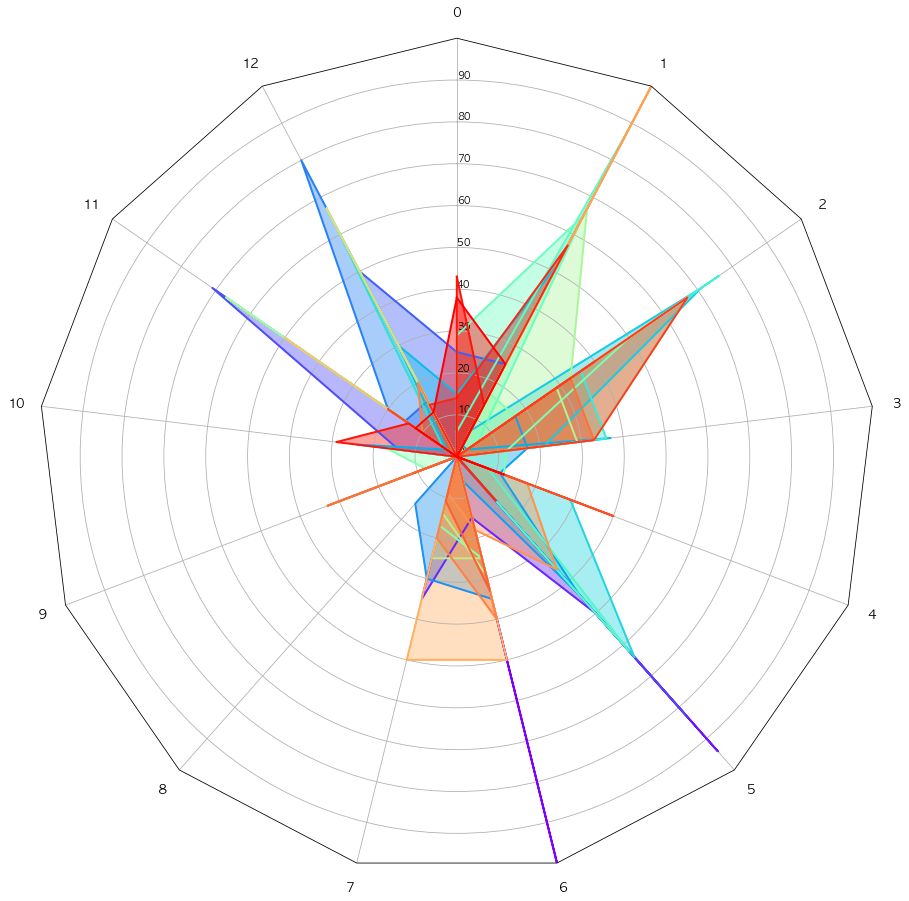

In [512]:
ms.visual_radar()

Mail Box Points Save Success.


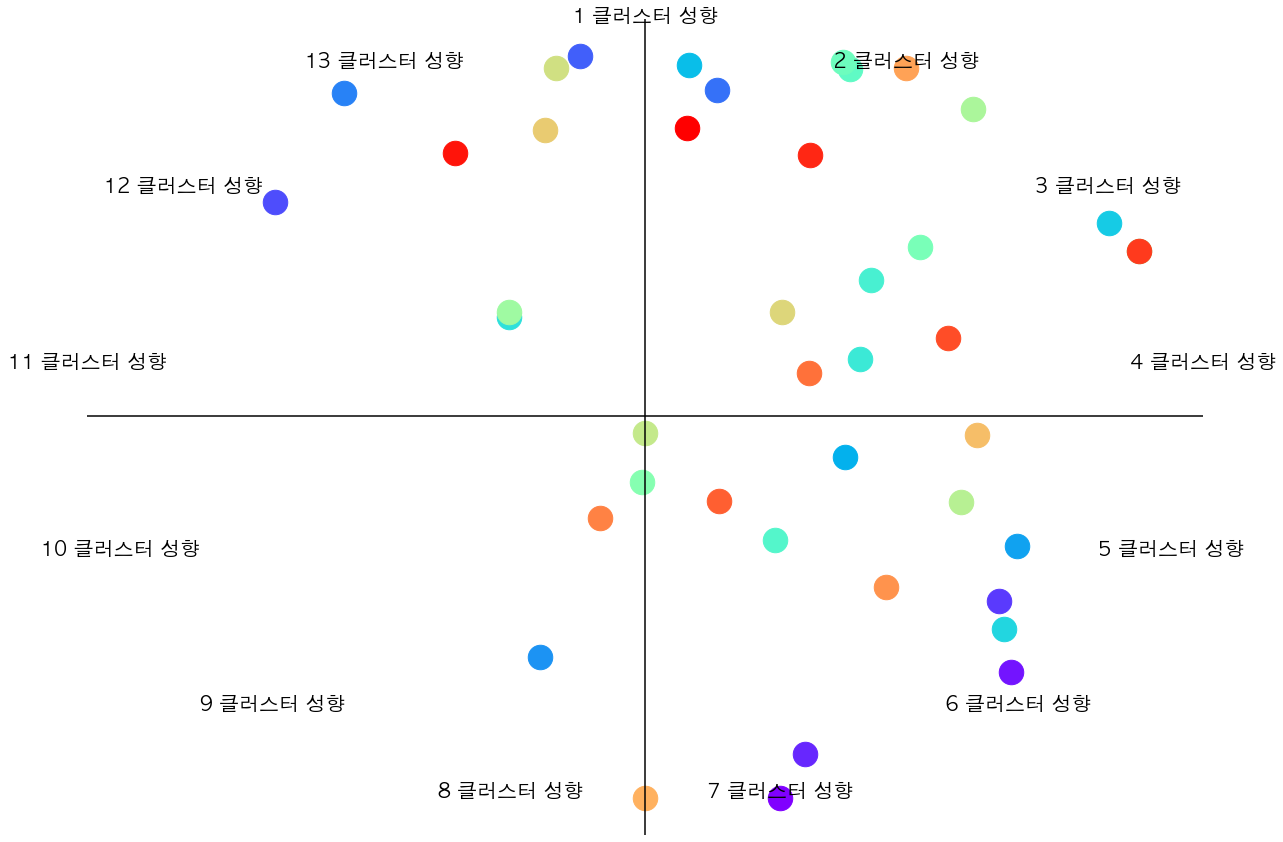

,x,y
623f2515ff1c441a392ab38c,23.931566,-97.094182
623f2515ff1c441a392ab38d,65.121869,-65.047274
623f2515ff1c441a392ab38e,28.369820,-85.972628
623f2515ff1c441a392ab38f,62.939475,-47.073640
623f2515ff1c441a392ab390,-65.823654,54.416495


In [513]:
ms.make_coord()
ms.visual_coord()

ms.mail_box_points.head()

# 유사도 확인

In [514]:
norm_features = ms.norm_features
mail_box_points = ms.mail_box_points
mail_box_col = ms.mail_box

norm_features.head()

,id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,0.557221,0.030677,0.454545,0.259920,0.083760,0.993969,0.981112,0.119325,0.357399,0.426436
1,3UPjb91Fwm7u2tAm92Bk0p,0.450954,0.529227,0.636364,0.820022,0.035348,0.812049,0.000000,0.072191,0.219311,0.482922
2,3dbLT62Cvs46Ju7a8gpr36,0.686649,0.889710,0.818182,0.967201,0.264857,0.124570,0.000012,0.283056,0.698815,0.596867
3,2FWquqPNxte8iqZ3ATQG0p,0.245232,0.731424,0.727273,0.788933,0.564549,0.378857,0.000000,0.095386,0.434598,0.265127
4,3gzIK2dGSVvPBiohsTwEWZ,0.566757,0.573138,0.000000,0.746269,0.059170,0.058335,0.000177,0.114364,0.639013,0.570288


### 반경 내 유사도 측정

In [515]:
from bson import ObjectId

In [516]:
# query 예시

# 반경 50 내의 데이터만을 가지고 유사도 측정
rate =50
evaluate_pd_1 = pd.DataFrame()
for box_id in ms.mail_box_points.index.values:
    x, y = ms.mail_box_points.loc[box_id].values

    min_x = x - rate
    max_x = x + rate

    min_y = y - rate
    max_y = y + rate

    res = mail_box_col.find({
        "$and": [
            {"coord.x": { "$gte": min_x }},
            {"coord.x": { "$lte": max_x }},
            {"coord.y": { "$gte": min_y }},
            {"coord.y": { "$lte": max_y }},
        ]
    })

    track_info = pd.DataFrame()
    for _ in res:
        _id = str(_["_id"])
        track_list = _['tracks']

        _track_info = pd.DataFrame(track_list)
        _track_info['box_id'] = _id
        track_info = pd.concat([track_info, _track_info],ignore_index=True)

    track_info.head()

    my_track = track_info[track_info['box_id'] == box_id]['track_id']
    reco_track = track_info[track_info['box_id'] != box_id]['track_id']

    my_track.name = 'id'
    reco_track.name = 'id'

    my_track = pd.merge(my_track, norm_features, how='inner', on='id')
    reco_track = pd.merge(reco_track, norm_features, how='inner', on='id')

    euc_mean = euc(my_track.values[:,1:], reco_track.values[:, 1:]).mean()
    evaluate_pd_1 = evaluate_pd_1.append(pd.Series({
        "평균 거리": euc_mean
    }, name=box_id))
    
print("반경 내 테스트 : {}".format(evaluate_pd_1['평균 거리'].mean()))

반경 내 테스트 : 0.8559177105731021


### 반경 외 유사도 측정

In [517]:
# query 예시

# 반경 100 외의 데이터만을 가지고 유사도 측정
rate = 80
evaluate_pd_2 = pd.DataFrame()
for box_id in ms.mail_box_points.index.values:
    x, y = ms.mail_box_points.loc[box_id].values

    min_x = x - rate
    max_x = x + rate

    min_y = y - rate
    max_y = y + rate

    res = mail_box_col.find({
        "$or": [
            {"_id": ObjectId(box_id)},
            {"$or": [
                {"coord.x": { "$lt": min_x }},
                {"coord.x": { "$gt": max_x }},
                {"coord.y": { "$lt": min_y }},
                {"coord.y": { "$gt": max_y }},
            ]}
        ]
    })

    track_info = pd.DataFrame()
    for _ in res:
        _id = str(_["_id"])
        track_list = _['tracks']

        _track_info = pd.DataFrame(track_list)
        _track_info['box_id'] = _id
        track_info = pd.concat([track_info, _track_info],ignore_index=True)

    track_info.head()

    my_track = track_info[track_info['box_id'] == box_id]['track_id']
    reco_track = track_info[track_info['box_id'] != box_id]['track_id']

    my_track.name = 'id'
    reco_track.name = 'id'

    my_track = pd.merge(my_track, norm_features, how='inner', on='id')
    reco_track = pd.merge(reco_track, norm_features, how='inner', on='id')
    
    euc_mean = euc(my_track.values[:,1:], reco_track.values[:, 1:]).mean()
    evaluate_pd_2 = evaluate_pd_2.append(pd.Series({
        "평균 거리": euc_mean
    }, name=box_id))
    
print("반경 외 테스트 : {}".format(evaluate_pd_2['평균 거리'].mean()))

반경 외 테스트 : 1.16957626725446


In [518]:
evaluate_pd = pd.DataFrame(columns=['반경 내 테스트', '반경 외 테스트'])

evaluate_pd['반경 내 테스트'] = evaluate_pd_1['평균 거리']
evaluate_pd['반경 외 테스트'] = evaluate_pd_2['평균 거리']
evaluate_pd['오차'] = evaluate_pd['반경 내 테스트'] - evaluate_pd['반경 외 테스트']

print("반경 내, 반경 외 평균 오차는 {} 입니다.".format(evaluate_pd['오차'].mean()))

evaluate_pd.head()

반경 내, 반경 외 평균 오차는 -0.31365855668135856 입니다.


,반경 내 테스트,반경 외 테스트,오차
623f2515ff1c441a392ab38c,1.112841,1.706422,-0.593581
623f2515ff1c441a392ab38d,0.736324,0.979093,-0.242769
623f2515ff1c441a392ab38e,0.911214,1.375064,-0.463850
623f2515ff1c441a392ab38f,0.819066,1.002906,-0.183840
623f2515ff1c441a392ab390,1.015017,1.148670,-0.133653


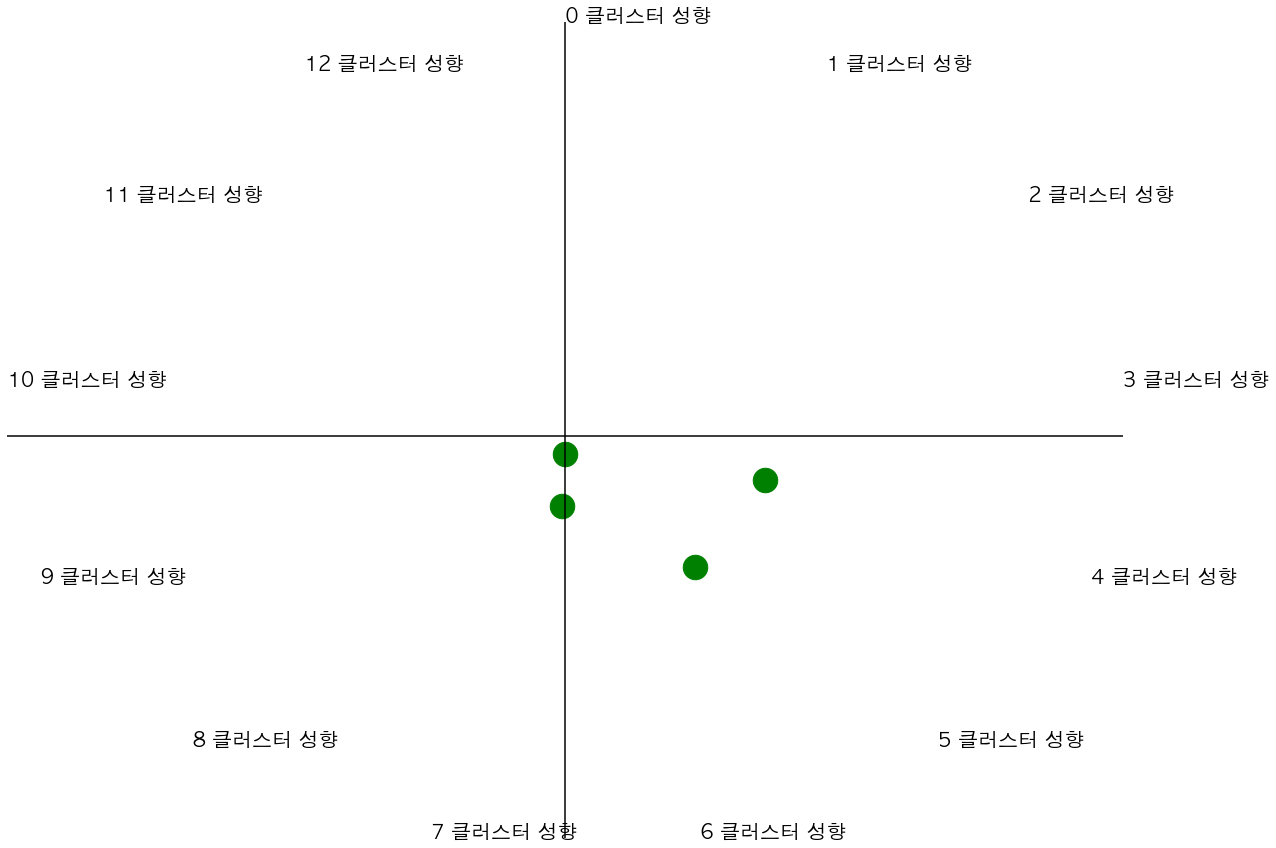

In [519]:
err_datas = ms.mail_box_points.loc[evaluate_pd[evaluate_pd['오차'] > 0].index].copy()

plt.figure(figsize=(20, 15))

for idx, pt in enumerate(err_datas.values):
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='g', label=ms.mail_box_radar.index[idx])
    
for idx, pt in enumerate(ms.max_coord):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    ms.max_coord[:,0].min(),
    ms.max_coord[:,0].max()
])
plt.yticks([
    ms.max_coord[:,1].min(),
    ms.max_coord[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

### 오차 제거 반경 내 데이터 성능 평가

In [520]:
# query 예시

# 반경 내의 데이터만을 가지고 유사도 측정
rate = 50
evaluate_pd_1 = pd.DataFrame()
for box_id in ms.mail_box_points.index.values:
    if box_id in err_datas.index.values:
        continue
    
    x, y = ms.mail_box_points.loc[box_id].values

    min_x = x - rate
    max_x = x + rate

    min_y = y - rate
    max_y = y + rate

    res = mail_box_col.find({
        "$and": [
            {"coord.x": { "$gte": min_x }},
            {"coord.x": { "$lte": max_x }},
            {"coord.y": { "$gte": min_y }},
            {"coord.y": { "$lte": max_y }},
        ]
    })

    track_info = pd.DataFrame()
    for _ in res:
        _id = str(_["_id"])
        track_list = _['tracks']

        _track_info = pd.DataFrame(track_list)
        _track_info['box_id'] = _id
        track_info = pd.concat([track_info, _track_info],ignore_index=True)

    track_info.head()

    my_track = track_info[track_info['box_id'] == box_id]['track_id']
    reco_track = track_info[track_info['box_id'] != box_id]['track_id']

    my_track.name = 'id'
    reco_track.name = 'id'

    my_track = pd.merge(my_track, norm_features, how='inner', on='id')
    reco_track = pd.merge(reco_track, norm_features, how='inner', on='id')

    euc_mean = euc(my_track.values[:,1:], reco_track.values[:, 1:]).mean()
    evaluate_pd_1 = evaluate_pd_1.append(pd.Series({
        "평균 거리": euc_mean
    }, name=box_id))
    
print("반경 내 테스트 : {}".format(evaluate_pd_1['평균 거리'].mean()))

반경 내 테스트 : 0.8325298696272905


In [521]:
evaluate_pd = pd.DataFrame(columns=['반경 내 테스트', '반경 외 테스트'])

evaluate_pd['반경 내 테스트'] = evaluate_pd_1['평균 거리']
evaluate_pd['반경 외 테스트'] = evaluate_pd_2['평균 거리']
evaluate_pd['오차'] = evaluate_pd['반경 내 테스트'] - evaluate_pd['반경 외 테스트']

print("반경 내, 반경 외 평균 오차는 {} 입니다.".format(evaluate_pd['오차'].mean()))

evaluate_pd.head()

반경 내, 반경 외 평균 오차는 -0.3516359514726123 입니다.


,반경 내 테스트,반경 외 테스트,오차
623f2515ff1c441a392ab38c,1.112841,1.706422,-0.593581
623f2515ff1c441a392ab38d,0.736324,0.979093,-0.242769
623f2515ff1c441a392ab38e,0.911214,1.375064,-0.463850
623f2515ff1c441a392ab38f,0.819066,1.002906,-0.183840
623f2515ff1c441a392ab390,1.015017,1.148670,-0.133653


In [525]:
check_type = "idx" # or id

check_idx = evaluate_pd['오차'].abs().argmax()
check_id = "623f2746ff1c441a392ab410"

rate_x = 50
rate_y = 50

if check_type != "idx":
    _my_box_id = ms.mail_box_points.loc[check_id].name
    user_centroid = ms.mail_box_points.loc[check_id].values
else:
    _my_box_id = ms.mail_box_points.iloc[check_idx].name
    user_centroid = ms.mail_box_points.iloc[check_idx].values
    
user_x, user_y = user_centroid

print(_my_box_id)
print("user x: {}, user y: {}".format(user_x, user_y))

search_box = ms.mail_box_points[
    ((ms.mail_box_points['x'] < (user_x + rate_x)) & (ms.mail_box_points['x'] > (user_x - rate_x))) &
    ((ms.mail_box_points['y'] < (user_y + rate_y)) & (ms.mail_box_points['y'] > (user_y - rate_y)))
]

search_box

623f2abcff1c441a392ab4ca
user x: -15.80058784948812, user y: 88.54560256532099


,x,y
623f2515ff1c441a392ab391,-11.618079,91.409202
623f2516ff1c441a392ab392,12.750293,82.899277
623f2516ff1c441a392ab393,-53.637531,82.197777
623f2745ff1c441a392ab40b,7.754958,89.311588
623f2abcff1c441a392ab4ca,-15.800588,88.545603
623f2abcff1c441a392ab4cc,-17.913035,72.676039
623f2e6dff1c441a392ab502,29.266814,66.388227
623fd87941b77810641388aa,-33.804207,66.844855
6241924d2aaa4bb999f6d5ca,7.385790,73.323391


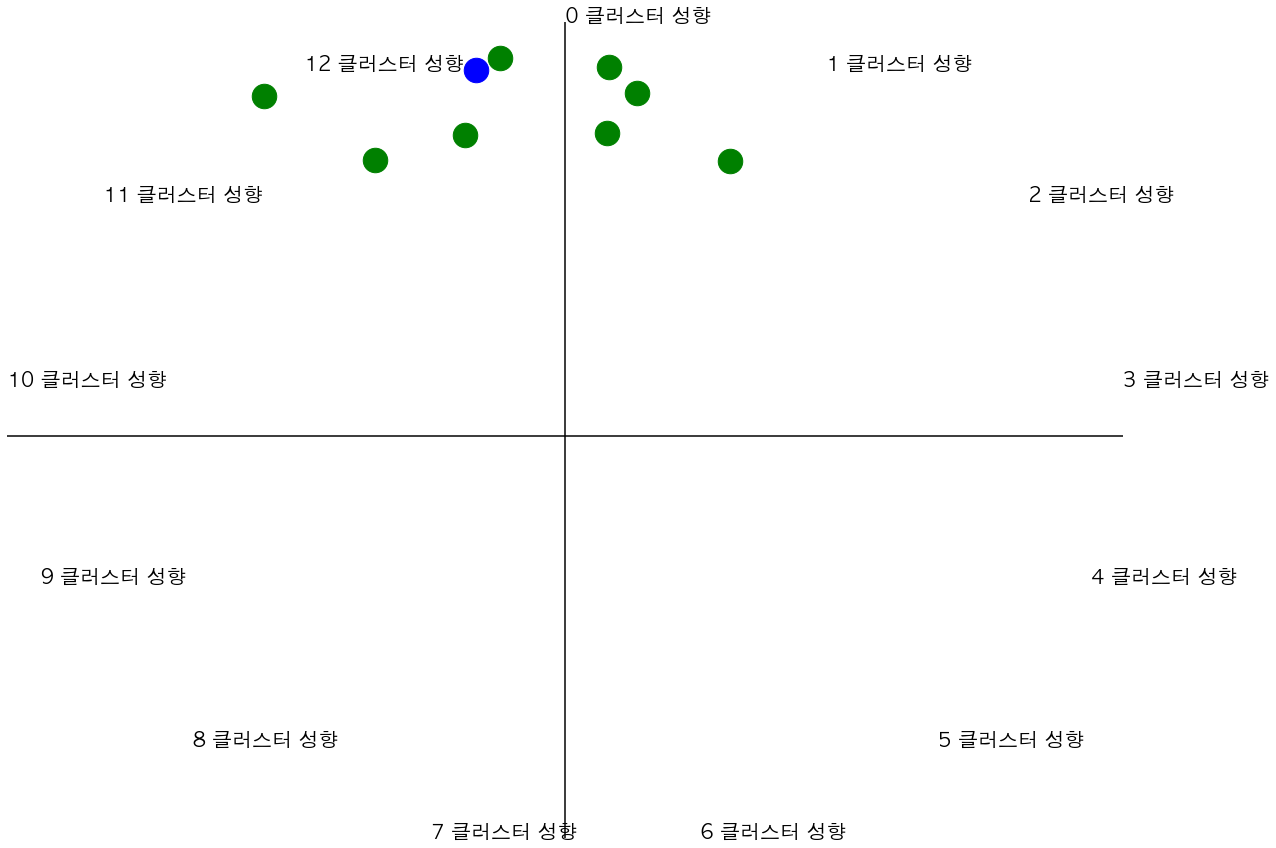

In [526]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=ms.mail_box_radar.index[idx])
    
for idx, pt in enumerate(ms.max_coord):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    ms.max_coord[:,0].min(),
    ms.max_coord[:,0].max()
])
plt.yticks([
    ms.max_coord[:,1].min(),
    ms.max_coord[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [527]:
tracks = pd.DataFrame()
reco_ids = list()

for box in ms.mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2515ff1c441a392ab391
1,2qJjNAljfrYm7slPCXzRtC,Shine,1dTvYIUWdOcBXYyUWhi91W,Girls Planet 999,623f2515ff1c441a392ab391
2,6tU92qp9bJWAW86IHUggUa,Summer or Summer,"78sJswwVn4P8aEhkF4K6fQ,6xxFNpc17jiiVZzOCgdLyv","Hyolyn,DASOM",623f2515ff1c441a392ab391
3,0S6giCcEzgm7SzK6cczMKc,Q&A,3IJCdgkBZbieocLZ4e94GZ,Cherry Bullet,623f2515ff1c441a392ab391
4,2FWquqPNxte8iqZ3ATQG0p,All I Wanna Do (K) (Feat. Hoody & Loco),4XDi67ZENZcbfKnvMnTYsI,Jay Park,623f2516ff1c441a392ab392


In [528]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2515ff1c441a392ab391,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
1,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2516ff1c441a392ab392,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
2,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2745ff1c441a392ab40b,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
3,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2abcff1c441a392ab4ca,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867
4,3dbLT62Cvs46Ju7a8gpr36,Savage,6YVMFz59CuY7ngCxTxjpxE,aespa,623f2abcff1c441a392ab4cc,0.686649,0.88971,0.818182,0.967201,0.264857,0.12457,0.000012,0.283056,0.698815,0.596867


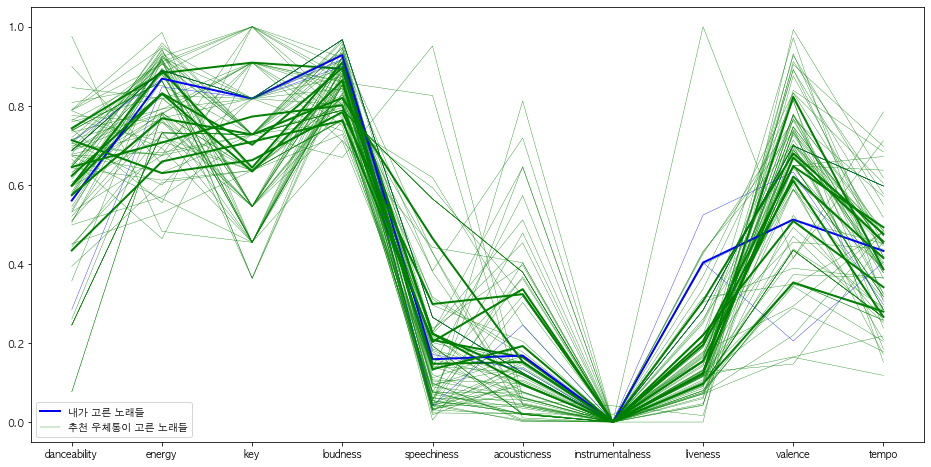

In [529]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [530]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = my_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 0.5582805436587371


In [531]:
rate_x = 100
rate_y = 100

if check_type != "idx":
    _my_box_id = ms.mail_box_points.loc[check_id].name
    user_centroid = ms.mail_box_points.loc[check_id].values
else:
    _my_box_id = ms.mail_box_points.iloc[check_idx].name
    user_centroid = ms.mail_box_points.iloc[check_idx].values

user_x, user_y = user_centroid

search_box = ms.mail_box_points[~(
    ((ms.mail_box_points['x'] < (user_x + rate_x)) & (ms.mail_box_points['x'] > (user_x - rate_x))) &
    ((ms.mail_box_points['y'] < (user_y + rate_y)) & (ms.mail_box_points['y'] > (user_y - rate_y)))
)]

search_box = search_box.append(ms.mail_box_points.iloc[check_idx])
search_box = search_box.append(ms.mail_box_points.loc[check_id])

search_box.head()

,x,y
623f2515ff1c441a392ab38c,23.931566,-97.094182
623f2515ff1c441a392ab38d,65.121869,-65.047274
623f2515ff1c441a392ab38e,28.369820,-85.972628
623f2515ff1c441a392ab38f,62.939475,-47.073640
623f2516ff1c441a392ab394,-18.771404,-61.390628


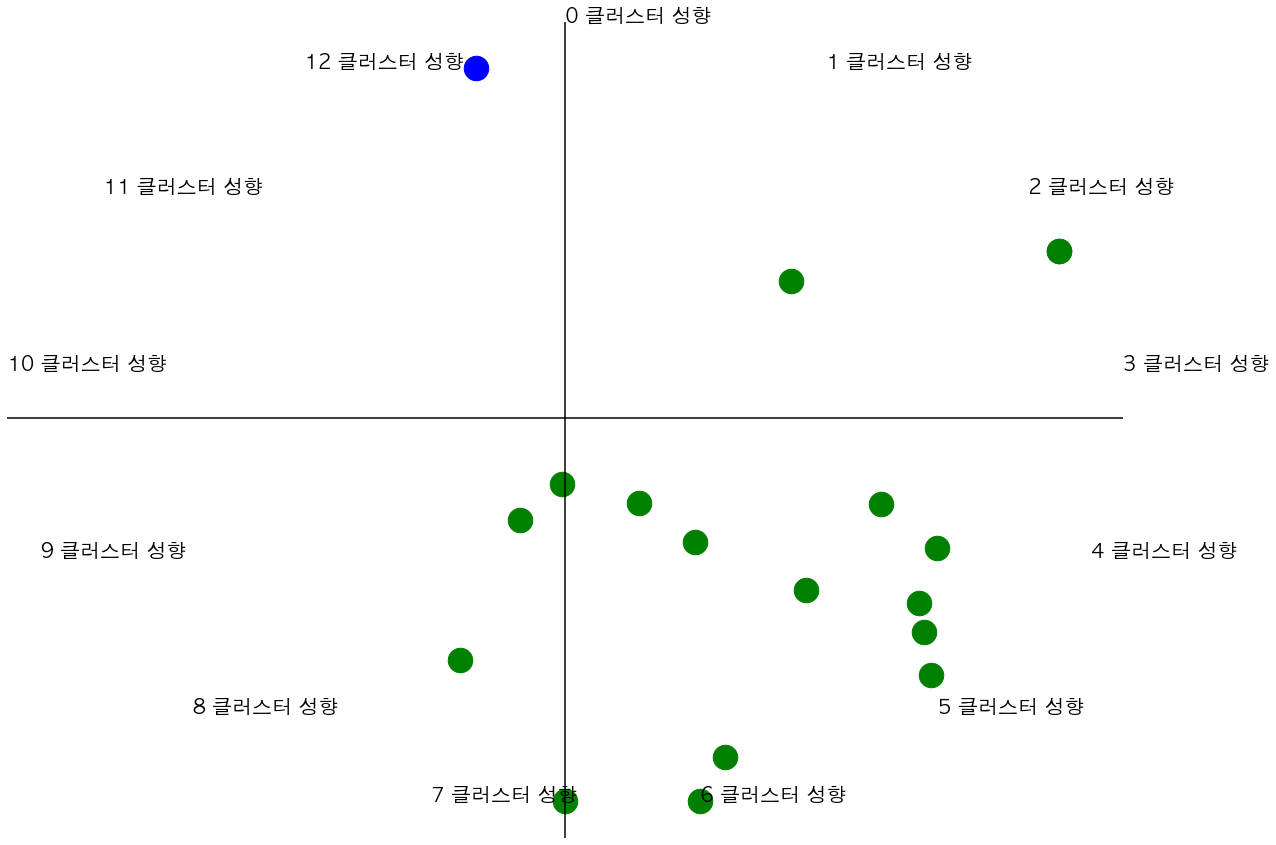

In [532]:
plt.figure(figsize=(20, 15))

for idx, pt in enumerate(search_box.values):
    b_id = search_box.index[idx]
    
    x = pt[0]
    y = pt[1]
    plt.scatter(x, y, s=600, color='b' if b_id == _my_box_id else 'g', label=ms.mail_box_radar.index[idx])
    
for idx, pt in enumerate(ms.max_coord):
    plt.text(pt[0], pt[1],"{} 클러스터 성향".format(idx), fontsize=20)

plt.xticks([
    ms.max_coord[:,0].min(),
    ms.max_coord[:,0].max()
])
plt.yticks([
    ms.max_coord[:,1].min(),
    ms.max_coord[:,1].max()
])

plt.axhline(
    0, color='black'
)
plt.axvline(
    0, color='black'
)
plt.axis("off")
# plt.legend()

plt.show()

In [533]:
tracks = pd.DataFrame()
reco_ids = list()

for box in ms.mail_boxes:
    _id = box['_id']
    
    if str(_id) in search_box.index:
        _box_tracks = pd.DataFrame(box['tracks'])
        _box_tracks['box_id'] = str(_id)
        
        tracks = pd.concat([tracks,_box_tracks], ignore_index=True)
        reco_ids.append(str(_id))
        
tracks.rename({"track_id": "id"}, axis=1,inplace=True)
tracks.head()

,id,name,artists,artists_name,box_id
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,623f2515ff1c441a392ab38c
2,79chL6wRWGUCF5V5qKZtf0,Clair de Lune - Debussy,22pAlZRKZ8WyPTtf63Y5nV,Exam Study Classical Music Orchestra,623f2515ff1c441a392ab38c
3,58yFroDNbzHpYzvicaC0de,Peace Piece,4jXfFzeP66Zy67HM2mvIIF,Bill Evans,623f2515ff1c441a392ab38c
4,7KRaeLuGqHJNhU3V3Vw67Z,Dark Night of the Soul,7xaLfXBI5MSy3aNX7m4X3O,Philip Wesley,623f2515ff1c441a392ab38c


In [534]:
merge_features = pd.merge(tracks, norm_features, on="id")

merge_features.head()

,id,name,artists,artists_name,box_id,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38c,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
1,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2515ff1c441a392ab38e,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
2,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab394,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
3,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2516ff1c441a392ab395,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436
4,7tIOwGFRTM08JdAeKOELGp,Blue room,3rxeQlsv0Sc2nyYaZ5W71T,Chet Baker,623f2abbff1c441a392ab4c4,0.557221,0.030677,0.454545,0.25992,0.08376,0.993969,0.981112,0.119325,0.357399,0.426436


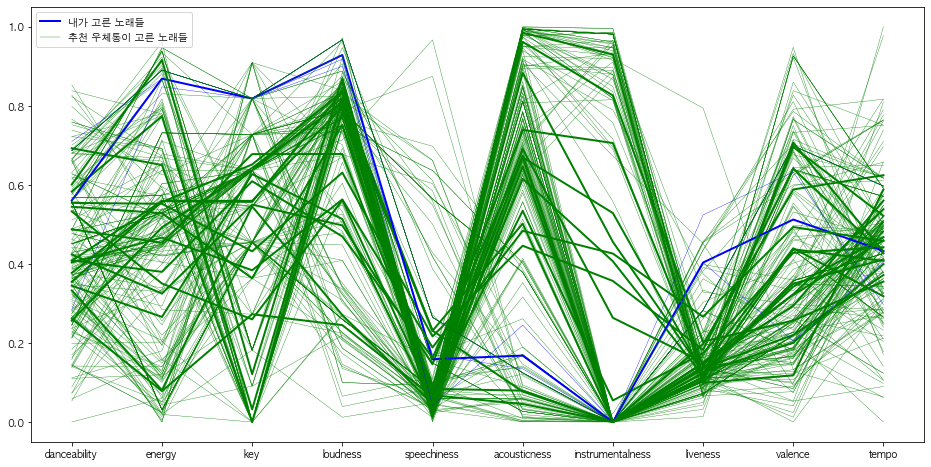

In [535]:
feature_columns = ['danceability',
       'energy', 'key', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(16,8))

for box_id in reco_ids:
    _features = merge_features[
        merge_features['box_id'] == box_id
    ]
    
    plt.plot(_features[feature_columns].T.mean(axis=1), color='b' if box_id == _my_box_id else 'g',
            linewidth=2, label='내가 고른 노래들' if box_id == _my_box_id else '추천 우체통이 고른 노래들')
    plt.plot(_features[feature_columns].T, color='b' if box_id == _my_box_id else 'g',
            linewidth=0.35)


plt.xticks(feature_columns)
leg = plt.legend(['내가 고른 노래들', '추천 우체통이 고른 노래들'])

leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('g')

plt.show()

In [536]:
my_features = merge_features[
    merge_features['box_id'] == _my_box_id
]
my_mean = my_features[feature_columns].mean(axis=0).values
my_mean = np.expand_dims(my_mean, axis=0)

reco_features = merge_features[
    merge_features['box_id'] != _my_box_id
]
reco_features = reco_features[feature_columns].values

print("평균 노래 거리 차이 :",euc(my_mean,
   reco_features)[0].mean())

평균 노래 거리 차이 : 1.088575175350753
